# Setup

In [ ]:
# !git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
# %cd /content/medium-skill-based-agents
# !ls

Cloning into 'medium-skill-based-agents'...
remote: Enumerating objects: 17466, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17466 (delta 8), reused 20 (delta 7), pack-reused 17439 (from 2)
Receiving objects: 100% (17466/17466), 153.10 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (7866/7866), done.
Updating files: 100% (33/33), done.
/content/medium-skill-based-agents
 agents				    pyproject.toml     train_autoenc.py
 configs.yaml			    README.md	       train_usr.py
 convert_to_pt.py		    skills	       train_vok.py
 create_dataset.py		    test_packages.py   train_vos.py
 environment_configs		    test_train.py      utils
 MANIFEST.in			    test_vok.ipynb     uv.lock
'[Medium]Skilled_RL_Agents.ipynb'   test_vos.ipynb


In [ ]:
!uv --version

uv 0.9.17


In [ ]:
# ! yes | pip uninstall gym

In [ ]:
# !uv pip install -r pyproject.toml

Using Python 3.12.12 environment at: /usr
Resolved 148 packages in 7.55s
Prepared 45 packages in 1m 19s
Uninstalled 11 packages in 1.98s
Installed 45 packages in 990ms
 + atariari==0.0.1 (from git+https://github.com/Sopralapanca/atari-representation-learning.git@9cc4c53fa44f45c14061343b57e8a40e25945028)
 + colorlog==6.10.1
 + comm==0.2.3
 + dataproperty==1.1.0
 - gym==0.25.2
 + gym==0.26.2
 - gymnasium==1.2.2
 + gymnasium==1.2.3
 + huggingface-sb3==3.0
 - ipykernel==6.17.1
 + ipykernel==7.1.0
 + jedi==0.19.2
 - jupyter-client==7.4.9
 + jupyter-client==8.7.0
 + kornia==0.8.2
 + kornia-rs==0.1.10
 + mbstrdecoder==1.1.4
 - moviepy==1.0.3
 + moviepy==2.2.1
 + nvidia-cublas-cu12==12.8.4.1
 + nvidia-cuda-cupti-cu12==12.8.90
 + nvidia-cuda-nvrtc-cu12==12.8.93
 + nvidia-cuda-runtime-cu12==12.8.90
 + nvidia-cudnn-cu12==9.10.2.21
 + nvidia-cufft-cu12==11.3.3.83
 + nvidia-cufile-cu12==1.13.1.3
 + nvidia-curand-cu12==10.3.9.90
 + nvidia-cusolver-cu12==11.7.3.90
 + nvidia-cusparse-cu12==12.5.8.93
 

In [ ]:
# !python create_dataset.py

In [ ]:
# !python train_vos.py
# !python train_vok.py
# !python train_usr.py

Import the required packages, build the environment and test if it works

In [1]:
# general imports
import torch
import yaml
import numpy as np
import random
import os

# training imports
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

import matplotlib.pyplot as plt

# IMPORTANT - REGISTER THE ENVIRONMENTS
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Load config
_config_path = "./configs.yaml"

_config = {}
with open(_config_path, "r") as f:
    _config = yaml.safe_load(f) or {}


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # ignore tensorflow warnings about CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = None
if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


#envs = _config.get("ENVS", ["PongNoFrameskip-v4"])[0]
env = "PongNoFrameskip-v4"
with open(f'environment_configs/{env}.yaml', 'r') as file:
        environment_configuration = yaml.safe_load(file)["config"]

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
def create_env(env_id, configs, seed=None):
    env = make_atari_env(env_id, n_envs=configs["n_envs"], seed=seed)
    env = VecFrameStack(env, n_stack=configs["n_stacks"])
    env = VecTransposeImage(env)
    return env

In [3]:
import wandb
from dotenv import load_dotenv

load_dotenv()


key = os.getenv("WANDB_API_KEY")
if key is None:
    raise ValueError("WANDB_API_KEY not set")

def init_wandb(environment_configuration):
  wandb.login(key=key)

  tags = [
      f"fe:{environment_configuration['f_ext_name']}",
      f"game:{environment_configuration['game']}",
  ]

  run = wandb.init(
      project="medium-skill-based-agents",
      config=environment_configuration,
      sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
      monitor_gym=False,  # auto-upload the videos of agents playing the game
      group=f"{environment_configuration['game']}",
      tags=tags
      # save_code = True,  # optional
  )

  return run

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


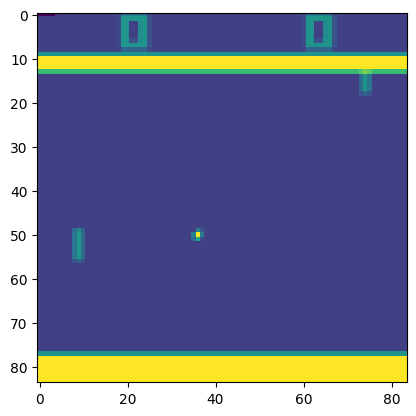

In [4]:
test_envs = create_env(env_id=env, configs=environment_configuration, seed=seed)

# execute some steps with random moves
obs = test_envs.reset()

for i in range(10):
    action = [test_envs.action_space.sample() for _ in range(environment_configuration["n_envs"])]
    obs, rewards, dones, info = test_envs.step(action)

# obs[0] has shape (4, 84, 84) because there are 4 stacked environments, take the first
observation = obs[0][-1]
plt.imshow(observation)
plt.show()



Utility function for training agents

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
from wandb.integration.sb3 import WandbCallback
from stable_baselines3 import PPO
from rl_zoo3.utils import linear_schedule


def train_agent(env_id, configs, policy_kwargs, seed):
    
    #run = init_wandb(configs)
    logdir = "./tensorboard_logs"
    
    # monitor_dir = str(run.id)
    monitor_dir = "ppo"

    vec_envs = create_env(env_id=env_id, configs=configs, seed=seed)
    _ = vec_envs.reset()
    
    eval_envs = create_env(env_id=env_id, configs=configs, seed=None)

    model = PPO(
        "CnnPolicy",
        vec_envs,
        learning_rate=linear_schedule(environment_configuration["learning_rate"]),
        n_steps=environment_configuration["n_steps"],
        n_epochs=environment_configuration["n_epochs"],
        batch_size=environment_configuration["batch_size"],
        clip_range=linear_schedule(environment_configuration["clip_range"]),
        normalize_advantage=environment_configuration["normalize"],
        ent_coef=environment_configuration["ent_coef"],
        vf_coef=environment_configuration["vf_coef"],
        policy_kwargs=policy_kwargs,
        verbose=1,
        device=device,
        tensorboard_log=logdir,
    )


    eval_logs = f"eval_logs/{env}/{monitor_dir}"
    os.makedirs(eval_logs, exist_ok=True)

    eval_callback = EvalCallback(
        eval_envs,
        n_eval_episodes=100,
        best_model_save_path=f"./agents/{monitor_dir}",
        log_path=eval_logs,
        eval_freq=5000 * environment_configuration["n_envs"],
        verbose=0,
    )

    callbacks = [
        #WandbCallback(verbose=0),
        eval_callback
    ]

    model.learn(5000, callback=callbacks, progress_bar=True) #tb_log_name=run.id)
    #run.finish()


/home/giacomo/Documents/code-projects/medium-skill-based-agents/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train Standard PPO Agent

In [6]:
policy_kwargs = dict(
    net_arch={
        "pi": environment_configuration["net_arch_pi"],
        "vf": environment_configuration["net_arch_vf"],
    },
    # activation_fn=torch.nn.ReLU,  # use ReLU in case of multiple layers for the policy learning network
)

#train_agent(env, environment_configuration, policy_kwargs, seed)



In [7]:
from skills.autoencoder import Autoencoder
from skills.unsupervised_state_representation import UnsupervisedStateRepresentationModel
from skills.video_object_keypoints import Transporter
from skills.video_object_segmentation import VideoObjectSegmentationModel

# init skills
autoencoder = Autoencoder(channels=1).to(device)

# observation has shape (32, 4, 84, 84),
# observation = obs[0][0][None, :, :] # (1, 84, 84)

print(obs[0].shape) # (4, 84, 84)

environment_configuration["f_ext_kwargs"]["device"] = device  #do not comment this, it is the parameter passed to the feature extractor
environment_configuration["game"] = env


usr = UnsupervisedStateRepresentationModel(observation=obs[0], device=device)
vok = Transporter().to(device)
vos = VideoObjectSegmentationModel(device=device)


skills = [
    usr.get_skill(device=device),
    vok.get_skill(device=device, keynet_or_encoder="encoder"),
    vok.get_skill(device=device, keynet_or_encoder="keynet"),
    vos.get_skill(device=device)
]

# Test each skill's input adapter
print("\nTesting skill input adapters:")
test_obs = obs[:1]  # Take one sample from batch
test_obs = torch.tensor(test_obs, dtype=torch.float32).to(device)

for skill in skills:
    print(f"\nSkill: {skill.name}")
    print(f"Input shape: {test_obs.shape}")
    adapted = skill.input_adapter(test_obs)
    print(f"After adapter: {adapted.shape}")

(4, 84, 84)


/home/giacomo/Documents/code-projects/medium-skill-based-agents/.venv/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Testing skill input adapters:

Skill: state_rep_uns
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 160, 210])

Skill: obj_key_enc
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: obj_key_key
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: vid_obj_seg
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 2, 84, 84])


Train WSA agent

In [ ]:
from utils.feature_extractors import WeightSharingAttentionExtractor

f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)


Using cpu device
Logging to ./tensorboard_logs/PPO_10
-----------------------------
| time/              |      |
|    fps             | 66   |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 103          |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0008237411 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.0488       |
|    entropy_loss         | -1.79        |
|    explained_variance   | -0.013       |
|    learning_rate        | 0.000122     |
|    loss                 | 0.0236       |
|    n_updates            | 4            |
|    policy_gradient_loss | -0.000502    |
|    value_loss           | 0.187        |
-----

Train MOE agent

In [8]:
from utils.feature_extractors import MixtureOfExpertsExtractor

f_ext_kwargs = environment_configuration["f_ext_kwargs"]
environment_configuration["f_ext_name"] = "moe_ext"
environment_configuration["f_ext_class"] = MixtureOfExpertsExtractor
f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256

policy_kwargs["features_extractor_class"] = environment_configuration["f_ext_class"]
policy_kwargs["features_extractor_kwargs"] = f_ext_kwargs

train_agent(env, environment_configuration, policy_kwargs, seed)

Using cpu device
Logging to ./tensorboard_logs/PPO_18
Observations device: cpu


NameError: name 'exit' is not defined